<a href="https://colab.research.google.com/github/manmeet3/Masters_Project/blob/master/wip_colabs/5-ganomaly_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://www.groundai.com/project/ganomaly-semi-supervised-anomaly-detection-via-adversarial-training/1

https://github.com/chychen/tf2-ganomaly

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Masters_Project/Datasets/OASIS3/

/content/drive/.shortcut-targets-by-id/1bqqm9-0FMOqiqyH_NIQBh-lJ36pWa7aX/Masters_Project/Datasets/OASIS3


In [4]:
# %cd ganomaly_tf2
# !wget https://raw.githubusercontent.com/chychen/tf2-ganomaly/master/metrics.py
# !wget https://raw.githubusercontent.com/chychen/tf2-ganomaly/master/model.py
# !wget https://raw.githubusercontent.com/chychen/tf2-ganomaly/master/train.py

In [5]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)
import os
import time
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ganomaly_tf2.model import GANomaly
from absl import logging
logging.set_verbosity(logging.INFO)
logging.set_stderrthreshold(logging.INFO)

from typing import Any, Callable, Optional, Tuple
from PIL import Image
from sklearn.model_selection import train_test_split

2.4.1


In [6]:
def batch_resize(imgs, size: tuple):
    img_out = np.empty((imgs.shape[0],) + size)
    for i in range(imgs.shape[0]):
        img_out[i] = cv2.resize(imgs[i], size, interpolation=cv2.INTER_CUBIC)
    return img_out

In [7]:
class Option:
    def __init__(self):
        self.anomaly = 1 # the anomaly digit
        self.shuffle_buffer_size = 10000
        self.batch_size = 8
        self.isize = 256 # input size
        self.ckpt_dir = "ckpt"
        self.nz = 100 # latent dims
        self.nc = 1 # input channels
        self.ndf = 64 # number of discriminator's filters
        self.ngf = 64 # number of generator's filters
        self.extralayers = 0
        self.niter = 15 # number of training epochs
        self.lr = 2e-4 
        self.w_adv = 1. # Adversarial loss weight
        self.w_con = 50. # Reconstruction loss weight
        self.w_enc = 1. # Encoder loss weight.
        self.beta1 = 0.5
        self.encdims = None
            
opt = Option()

In [8]:
data_train, data_test = tf.keras.datasets.mnist.load_data()
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [9]:
def read_data(path, normal=True):
    data: Any = []
    labels = []
    
    for file_path in glob.glob(path):
        with open (file_path, 'rb') as f:
            # image needs to be a PIL image
            img = Image.open(f)
            # Resize all images 176, 256, 3 -> 256, 256, 0
            dsize = (256, 256)
            resized = img.resize(dsize)
            data.append(resized)
            labels.append(1 if normal else 0) 
    data = np.vstack(data).reshape(-1, 256, 256)
    data = data.transpose((0, 1, 2))  # convert to HWC
    return (data, labels)

In [10]:
train_image_number = 140 # Image slice from MRI scans to use for training data
#root_dir = '/content/drive/MyDrive/Masters_Project/Datasets/OASIS3/'
root = '/content/drive/MyDrive/Masters_Project/Datasets/OASIS3/'
non_ad_jpg_folder = 't1w_non_ad_jpgs/' + str(train_image_number) + '/'
ad_jpg_folder = 't1w_ad_jpgs/' + str(train_image_number) + '/'


ad_jpg_folder = os.path.join(root, ad_jpg_folder)
non_ad_jpg_folder = os.path.join(root, non_ad_jpg_folder)
    
print("="*5 + " Loading Data " + "="*5)
print(f"ad_jpg_folder: {ad_jpg_folder}")
print(f"non_ad_jpg_folder: {non_ad_jpg_folder}")

non_ad_data: Any = []
non_ad_targets = []

ad_data: Any = []
ad_targets = []

# Read data and label into a numpy array
non_ad_data, non_ad_targets = read_data(ad_jpg_folder+'**.jpg', normal=True)
ad_data, ad_targets = read_data(non_ad_jpg_folder+'**.jpg', normal=False)

# shuffle the datasets and bucket them as test and train
# (non_ad_data, non_ad_targets) = shuffle_associated_arrays(non_ad_data, non_ad_targets)
# (ad_data, ad_targets) = shuffle_associated_arrays(ad_data, ad_targets)

all_data = np.concatenate((non_ad_data, ad_data), axis=0)
all_targets = non_ad_targets + ad_targets

x_train, x_test, y_train, y_test =\
  train_test_split(all_data, all_targets, test_size=0.1, random_state=42)

===== Loading Data =====
ad_jpg_folder: /content/drive/MyDrive/Masters_Project/Datasets/OASIS3/t1w_ad_jpgs/140/
non_ad_jpg_folder: /content/drive/MyDrive/Masters_Project/Datasets/OASIS3/t1w_non_ad_jpgs/140/


In [11]:
x_train.shape

(1165, 256, 256)

In [12]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

y_train = np.array(y_train, dtype=np.intc)
y_test = np.array(y_test, dtype=np.intc)

In [13]:
x_train = batch_resize(x_train, (256, 256))[..., None]
x_test = batch_resize(x_test, (256, 256))[..., None]
# normalization
mean = x_train.mean()
stddev = x_train.std()
x_train = (x_train-mean)/stddev
x_test = (x_test-mean)/stddev
print(x_train.shape, x_train.shape)
# define abnoraml data and normal
# training data only contains normal
x_train = x_train[y_train!=opt.anomaly]
y_train = y_train[y_train!=opt.anomaly]
y_test = (y_test==opt.anomaly).astype(np.float32)
# tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_dataset = train_dataset.shuffle(opt.shuffle_buffer_size).batch(opt.batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(opt.batch_size, drop_remainder=False)

(1165, 256, 256, 1) (1165, 256, 256, 1)


In [14]:
train_dataset

<BatchDataset shapes: ((8, 256, 256, 1), (8,)), types: (tf.float64, tf.int32)>

In [15]:
test_dataset

<BatchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float64, tf.float32)>

In [16]:
ganomaly = GANomaly(opt, train_dataset, valid_dataset=None, test_dataset=test_dataset)

In [17]:
ganomaly.fit(opt.niter)

INFO:absl:re-init D, cost: 0.1660 secs
INFO:absl:epoch: 0, G_losses: 53.3708, D_losses: 6.8582, samples/sec: 9.2585


Saving to: ckpt/best


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets
INFO:absl:*** 	 Testing:   roc_auc: 0.4523   average_precision: 0.2458 ***


INFO:absl:epoch: 1, G_losses: 20.1367, D_losses: 7.6246, samples/sec: 14.6664


Saving to: ckpt/best


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets
INFO:absl:*** 	 Testing:   roc_auc: 0.4890   average_precision: 0.2858 ***


INFO:absl:epoch: 2, G_losses: 19.6690, D_losses: 7.6246, samples/sec: 14.7477


Saving to: ckpt/best


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets
INFO:absl:*** 	 Testing:   roc_auc: 0.5008   average_precision: 0.3054 ***


INFO:absl:epoch: 3, G_losses: 19.5648, D_losses: 7.6246, samples/sec: 14.6725


Saving to: ckpt/best


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets
INFO:absl:*** 	 Testing:   roc_auc: 0.5179   average_precision: 0.2682 ***


INFO:absl:epoch: 4, G_losses: 19.5144, D_losses: 7.6246, samples/sec: 14.6259


Saving to: ckpt/best


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets
INFO:absl:*** 	 Testing:   roc_auc: 0.5317   average_precision: 0.2742 ***


INFO:absl:epoch: 5, G_losses: 19.4007, D_losses: 7.6246, samples/sec: 14.6569


INFO:absl:	 Testing:   roc_auc: 0.5011   average_precision: 0.2632


INFO:absl:epoch: 6, G_losses: 19.4104, D_losses: 7.6246, samples/sec: 14.5635


INFO:absl:	 Testing:   roc_auc: 0.4875   average_precision: 0.2613


INFO:absl:epoch: 7, G_losses: 19.3690, D_losses: 7.6246, samples/sec: 14.4129


INFO:absl:	 Testing:   roc_auc: 0.5131   average_precision: 0.2683


INFO:absl:epoch: 8, G_losses: 19.5678, D_losses: 7.6246, samples/sec: 14.3475


INFO:absl:	 Testing:   roc_auc: 0.4358   average_precision: 0.2638


INFO:absl:epoch: 9, G_losses: 18.2753, D_losses: 7.6246, samples/sec: 14.1586


INFO:absl:	 Testing:   roc_auc: 0.5095   average_precision: 0.2781


INFO:absl:epoch: 10, G_losses: 17.6316, D_losses: 7.6246, samples/sec: 14.2081


INFO:absl:	 Testing:   roc_auc: 0.3904   average_precision: 0.2547


INFO:absl:epoch: 11, G_losses: 17.0114, D_losses: 7.6246, samples/sec: 14.1974


INFO:absl:	 Testing:   roc_auc: 0.4490   average_precision: 0.2539


INFO:absl:epoch: 12, G_losses: 16.6037, D_losses: 7.6246, samples/sec: 14.1965


INFO:absl:	 Testing:   roc_auc: 0.4099   average_precision: 0.2405


INFO:absl:epoch: 13, G_losses: 16.4741, D_losses: 7.6246, samples/sec: 14.2529


INFO:absl:	 Testing:   roc_auc: 0.5044   average_precision: 0.2695


INFO:absl:epoch: 14, G_losses: 16.0169, D_losses: 7.6246, samples/sec: 14.2729


INFO:absl:	 Testing:   roc_auc: 0.3871   average_precision: 0.2207


Loading from: ckpt/best


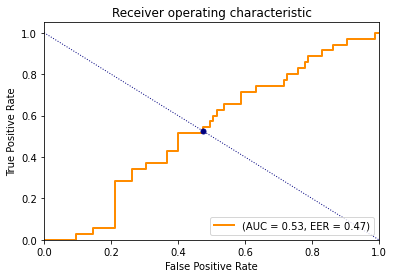

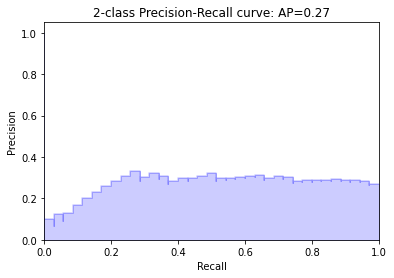

In [18]:
ganomaly.evaluate_best(test_dataset)

In [19]:
dir(ganomaly)

['D',
 'D_init_w_path',
 'G',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_evaluate',
 '_get_num_element',
 '_train_step_autograph',
 'best_state',
 'best_state_key',
 'best_state_policy',
 'd_loss',
 'd_optimizer',
 'err_d_fake',
 'err_d_real',
 'err_g_adv',
 'err_g_con',
 'err_g_enc',
 'evaluate',
 'evaluate_best',
 'fake_label',
 'feat_fake',
 'feat_real',
 'fit',
 'g_loss',
 'g_optimizer',
 'gen_img',
 'input',
 'l_adv',
 'l_bce',
 'l_con',
 'l_enc',
 'latent_i',
 'latent_o',
 'load',
 'load_best',
 'num_ele_train',
 'opt',
 'pred_fake',
 'pred_real',
 'real_label',
 'save',
 'save_best',
 'save_path',
 'test_dataset',
 'train_dataset',
 'train_step',
 'valid_

In [20]:
!ls

 cifar-10-batches-py	  ganomaly_pytorch    t1w_ad_jpgs
 cifar-10-python.tar.gz   ganomaly_tf2	      t1w_non_ad_jpgs
 ckpt			  oasis-scripts       t1w_non_ad_patients
 downloaded_data	  pre_rec_curve.png  'Usage Instructions.gdoc'
 fa20			  roc_auc.png


In [ ]:
#!mkdir -p ./ganomaly_tf2/output

In [21]:
ganomaly.save('./save_model/')

Saving to: ./save_model/


INFO:tensorflow:Assets written to: ./save_model/gen/assets


INFO:tensorflow:Assets written to: ./save_model/gen/assets


INFO:tensorflow:Assets written to: ./save_model/disc/assets


INFO:tensorflow:Assets written to: ./save_model/disc/assets


In [22]:
%mkdir -p saved_model

In [23]:
!ls

 cifar-10-batches-py	  ganomaly_tf2	      t1w_ad_jpgs
 cifar-10-python.tar.gz   oasis-scripts       t1w_non_ad_jpgs
 ckpt			  pre_rec_curve.png   t1w_non_ad_patients
 downloaded_data	  roc_auc.png	     'Usage Instructions.gdoc'
 fa20			  saved_model
 ganomaly_pytorch	  save_model


In [27]:
ganomaly.save_best()

Saving to: ckpt/best


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets


In [29]:
%ls ckpt/bestdisc/

assets/  saved_model.pb  variables/


In [30]:
!ls

 cifar-10-batches-py	  ganomaly_tf2	      t1w_ad_jpgs
 cifar-10-python.tar.gz   oasis-scripts       t1w_non_ad_jpgs
 ckpt			  pre_rec_curve.png   t1w_non_ad_patients
 downloaded_data	  roc_auc.png	     'Usage Instructions.gdoc'
 fa20			  saved_model
 ganomaly_pytorch	  save_model


In [31]:
test_dataset

<BatchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float64, tf.float32)>

In [32]:
D = tf.keras.models.load_model('save_model/disc')

In [35]:
x_test[0].shape

(256, 256, 1)

In [40]:
y_test[0]

0.0

In [43]:
D.predict(test_dataset)

(array([[[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[1.905391e-31]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        